## Setup dell'Ambiente e Ingestione Dati

In questa fase iniziale vengono importate le librerie necessarie per l'intero ciclo di vita del progetto e viene caricato il dataset grezzo delle traiettorie.

**1. Importazione delle dipendenze**
Il codice importa gli strumenti fondamentali suddivisi per funzionalità:
* **Manipolazione Dati:** `pandas` e `numpy` per la gestione di strutture dati tabulari e operazioni matriciali efficienti.
* **Deep Learning:** `tensorflow` e `tensorflow.keras` (inclusi `layers` e `Model`) costituiscono il framework per costruire le architetture neurali (RNN e Transformer).
* **Preprocessing:** `sklearn` (Scikit-learn) fornisce utility essenziali per:
    * `train_test_split`: dividere i dati in training e validation set.
    * `MinMaxScaler`: normalizzare i dati, passaggio cruciale per la convergenza delle reti neurali.
* **Visualizzazione:** `matplotlib.pyplot` per graficare le loss curves e i risultati delle predizioni.

**2. Caricamento del Dataset**
Viene definito il percorso del file e letto il CSV tramite `pd.read_csv`.
* **`header=None`**: Indica che la prima riga del file **non** contiene i nomi delle colonne, ma è già parte dei dati numerici. Pandas assegnerà indici numerici automatici (0, 1, 2...) alle colonne.
* **`index_col=False`**: Forza Pandas a non utilizzare la prima colonna come indice del DataFrame, che contiene i tempi.

Infine, `df.shape` restituisce una tupla `(n_righe, n_colonne)` per una verifica immediata della dimensionalità dei dati caricati.

In [26]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import gc
from tqdm import tqdm
import os

# 1. Caricamento del Dataset
FILE_PATH = '../data/trajectories.csv'

# Leggiamo senza header perché il file contiene solo numeri
df = pd.read_csv(FILE_PATH, header=None, index_col=False)

print(f"Dimensione totale dataset: {df.shape}")

Dimensione totale dataset: (400400, 56)


## Pre-elaborazione: Suddivisione delle Traiettorie

In questa sezione viene definita e utilizzata la funzione `split_trajectories`. Poiché il dataset originale contiene diverse simulazioni concatenate sequenzialmente, è necessario separarle per poter addestrare correttamente i modelli (RNN e Transformer) su sequenze indipendenti.

La logica della funzione è la seguente:

1.  **Rilevamento dei reset temporali**: La funzione isola la prima colonna (il tempo). Utilizzando `np.diff`, individua gli indici in cui il valore del tempo decresce (il passaggio da un tempo finale $t_{end}$ a un tempo iniziale $t_0$), che segnala l'inizio di una nuova traiettoria.
2.  **Splitting**: Il DataFrame viene diviso in una lista di array `numpy` in corrispondenza di questi punti di taglio.
3.  **Feature Selection**: Da ogni traiettoria viene rimossa la colonna del tempo (indice 0), mantenendo solo le feature fisiche (dalla colonna 1 in poi) che serviranno come input per la rete neurale.

Infine, viene eseguito lo split e vengono stampate le statistiche di base (numero di traiettorie e dimensione) per verifica.

In [17]:
def split_trajectories(df):
    trajectories = []
    
    # Identifichiamo dove il tempo ricomincia da capo (o è 0)
    # Se il tempo al passo t è minore del tempo al passo t-1, è una nuova traiettoria
    time_col = df.iloc[:, 0].values

    # Troviamo gli indici dove inizia una nuova traiettoria
    split_indices = np.where(np.diff(time_col) < 0)[0] + 1

    # Splittiamo il dataframe in questi punti
    traj_list = np.split(df.values, split_indices)

    # Rimuoviamo la colonna del tempo (col 0) dalle feature per il training
    # Teniamo solo le 55 colonne fisiche
    clean_trajectories = [t[:, 1:] for t in traj_list]

    return clean_trajectories

# Eseguiamo lo split
all_trajectories = split_trajectories(df)
print(f"Trovate {len(all_trajectories)} traiettorie distinte.")
print(f"Shape di una traiettoria: {all_trajectories[0].shape}")

Trovate 400 traiettorie distinte.
Shape di una traiettoria: (1001, 55)


## Split del Dataset e Normalizzazione

In questo blocco avvengono la separazione dei dati e la successiva normalizzazione.

**1. Divisione Train/Test**
Si utilizza `train_test_split` per dividere l'insieme delle traiettorie (`all_trajectories`) in due subset:
* **Training Set (80%):** Usato per l'addestramento dei pesi del modello.
* **Test Set (20%):** Usato esclusivamente per la valutazione finale delle performance su dati non visti.
* `random_state=42`: Garantisce la riproducibilità dell'esperimento fissando il seed del generatore pseudo-casuale.

**2. Normalizzazione (MinMax Scaling)**
Viene applicato un `MinMaxScaler` per scalare i dati nel range **[-1, 1]**, così da centrare i dati attorno allo zero, facilitando l'ottimizzazione e prevenendo problemi di gradienti.

**Prevenzione del Data Leakage**
Il codice rispetta rigorosamente la separazione tra train e test:
1.  **Fit solo sul Train:** Lo scaler calcola i valori minimi e massimi globali utilizzando **solo** i dati di training (`train_concat`). 
2.  **Transform:** I parametri appresi dal training vengono poi applicati per trasformare sia le traiettorie di training che quelle di test.

In [18]:
# Dividiamo le traiettorie in Train (80%) e Test (20%)
train_traj, test_traj = train_test_split(all_trajectories, test_size=0.2, random_state=42)

# Normalizzazione (MinMax tra 0 e 1 o -1 e 1 è standard per dati quantistici)
# Fittiamo lo scaler SOLO sul training set per correttezza metodologica
scaler = MinMaxScaler(feature_range=(-1, 1))

# Concateniamo temporaneamente per fittare lo scaler
train_concat = np.vstack(train_traj)
scaler.fit(train_concat)

# Applichiamo la trasformazione a ogni singola traiettoria
train_traj_norm = [scaler.transform(t) for t in train_traj]
test_traj_norm = [scaler.transform(t) for t in test_traj]

## Generazione del Dataset (Sliding Windows)

Questa funzione trasforma la lista di traiettorie grezze in un dataset strutturato per l'apprendimento supervisionato, utilizzando la tecnica delle **sliding windows**.

La funzione `create_dataset` opera come segue:

1.  **Iterazione per Traiettoria**: Itera su ogni singola simulazione (`trajectories`) separatamente. Questo serve per evitare che la fine di una simulazione venga usata per predire l'inizio di quella successiva.
2.  **Creazione Input ($X$)**: Estrae una finestra temporale di lunghezza `input_width`. Questa rappresenta il contesto storico che il modello osserverà.
3.  **Creazione Target ($y$)**: Estrae i passi temporali immediatamente successivi alla finestra di input, di lunghezza `forecast_horizon` (di default 1). Questo è ciò che il modello deve imparare a predire.

In [19]:
def create_dataset(trajectories, input_width, forecast_horizon=1):
    X, y = [], []
    for t in trajectories:
        for i in range(len(t) - input_width - forecast_horizon + 1):
            X.append(t[i : i + input_width])
            y.append(t[i + input_width : i + input_width + forecast_horizon])
    return np.array(X), np.array(y)

## Definizione dell'Architettura RNN (QuantumRNN)

In questo blocco viene definita la classe del modello neurale basata su unità ricorrenti **GRU**. Il modello è implementato tramite *subclassing* di `tf.keras.Model`, offrendo maggiore flessibilità e controllo sul flusso dei dati.

**Componenti dell'Architettura**

1.  **Layer Normalization:**
    * Applicata direttamente all'input. Normalizza le feature per ogni singolo campione indipendentemente dal batch. Serve per stabilizzare i gradienti e accelerare la convergenza.

2.  **Stacked GRU Layers:**
    * Vengono utilizzate due celle GRU in sequenza. Le GRU sono state scelte per la loro efficienza computazionale rispetto alle LSTM, pur risolvendo efficacemente il problema del *vanishing gradient*.
    * **GRU 1 (`return_sequences=True`):** Restituisce l'intera sequenza di output (un vettore per ogni step temporale). 
    * **GRU 2:** Restituisce solo l'**ultimo stato nascosto**. Questa configurazione implementa un'architettura **Many-to-One**, comprimendo l'informazione dell'intera sequenza storica in un unico vettore rappresentativo finale.

3.  **Regolarizzazione (Dropout):**
    * Vengono applicati due tipi di dropout per combattere l'overfitting:
        * `dropout`: Maschera casualmente gli input del layer.
        * `recurrent_dropout`: Maschera le connessioni ricorrenti (stato-stato), fondamentale per regolarizzare la memoria a lungo termine.

4.  **Output Layer (Dense):**
    * Un layer `Dense` finale senza funzione di attivazione (lineare) che proietta lo stato latente della GRU nella dimensione dell'output desiderato (`output_dim`, in questo caso 56 parametri per la regressione).

**Il Metodo `call` (Forward Pass)**
Definisce il flusso dei dati: `Input -> Norm -> GRU1 -> GRU2 -> Dense`.
* **Gestione del flag `training`:** Il parametro viene passato esplicitamente ai layer GRU. Questo assicura che il Dropout sia attivo **solo** durante il training (`model.fit`) e disattivato automaticamente durante la validazione o l'inferenza.

In [20]:
class QuantumRNN(Model):
    def __init__(self, hidden_units, output_dim, dropout_rate=0.2):
        super(QuantumRNN, self).__init__()

        # Layer di Normalizzazione
        self.norm = layers.LayerNormalization()

        # GRU 1: return_sequences=True per passare la sequenza alla seconda GRU
        # Aggiungiamo dropout e recurrent_dropout per regolarizzazione
        self.gru1 = layers.GRU(
            hidden_units,
            return_sequences=True,
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate
        )

        # GRU 2: Elabora la sequenza e restituisce solo l'ultimo stato
        self.gru2 = layers.GRU(
            hidden_units,
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate
        )

        # Dense Layer finale per la regressione (56 parametri)
        self.dense_out = layers.Dense(output_dim)

    def call(self, inputs, training=False):
        # Il parametro 'training' gestisce automaticamente il dropout:
        # viene attivato solo durante fit/train e disattivato durante la predizione
        x = self.norm(inputs)
        x = self.gru1(x, training=training)
        x = self.gru2(x, training=training)
        return self.dense_out(x)

## Architettura Transformer (Time Series)

Questo blocco implementa un modello **Transformer Encoder-only**, adattato per la previsione di serie temporali. A differenza delle RNN, che processano i dati sequenzialmente, il Transformer elabora l'intera finestra temporale in parallelo grazie al meccanismo di attenzione.

Il codice è suddiviso in due classi:

### 1. `TransformerBlock`
Rappresenta l'unità fondamentale dell'architettura. Ogni blocco applica le seguenti trasformazioni:
* **Multi-Head Self-Attention**: Permette al modello di mettere in relazione ogni passo temporale con tutti gli altri all'interno della finestra, catturando dipendenze a lungo raggio indipendentemente dalla distanza.
* **Feed Forward Network (FFN)**: Una rete densa a due strati che elabora le feature estratte dall'attenzione.
* **Add & Norm**: L'uso di connessioni residuali ($x + f(x)$) seguite da *Layer Normalization* è cruciale per stabilizzare i gradienti e permettere l'addestramento di reti profonde.

### 2. `QuantumTransformer`
È la classe che assembla i componenti:
1.  **Input Projection**: Un layer `Dense` proietta le 55 feature originali nello spazio latente di dimensione `embed_dim`.
2.  **Learnable Positional Encoding**: Poiché il meccanismo di attenzione è invariante all'ordine, viene sommato un vettore di pesi **addestrabili** (`pos_encoding`) all'input per fornire al modello informazioni sulla posizione temporale relativa.
3.  **Encoder Stack**: Una sequenza di `num_layers` blocchi Transformer ripetuti.
4.  **Global Average Pooling**: Invece di utilizzare solo l'ultimo step temporale, qui viene calcolata la media delle feature su tutta la sequenza temporale. Questo rende la predizione più robusta al rumore dei singoli step.
5.  **Output Head**: Un ultimo layer denso proietta il risultato verso la dimensione di output.

In [28]:
# --- BLOCCO TRANSFORMER ---
class EncoderBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(EncoderBlock, self).__init__()
        # 1. Multi-Head Attention
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        # 2. Feed Forward Network
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])

        # 3. Normalizzazione e Dropout
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        # Attention + Residual Connection + Norm
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        # Feed Forward + Residual Connection + Norm
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    
class DecoderBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(DecoderBlock, self).__init__()
        # Self Attention
        self.att1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # Cross Attention (Guarda l'Encoder)
        self.att2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"), 
            layers.Dense(embed_dim)
        ])
        
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.dropout3 = layers.Dropout(rate)

    def call(self, inputs, encoder_outputs, training=False):
        # 1. Self Attention (sul target/query)
        attn1 = self.att1(inputs, inputs)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(inputs + attn1)
        
        # 2. Cross Attention (Query=out1, Key/Value=encoder_outputs)
        attn2 = self.att2(out1, encoder_outputs)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(out1 + attn2)
        
        # 3. Feed Forward
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        return self.layernorm3(out2 + ffn_output)


# --- MODELLO COMPLETO ---
class QuantumTransformer(Model):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, output_dim, input_seq_len, dropout_rate=0.1):
        super(QuantumTransformer, self).__init__()
        self.input_seq_len = input_seq_len
        self.output_dim = output_dim
        
        # --- ENCODER ---
        self.input_embedding = layers.Dense(embed_dim)
        self.pos_encoding = self.add_weight(name="pos_enc", shape=(1, input_seq_len, embed_dim), initializer="zeros", trainable=True)
        self.encoder_blocks = [EncoderBlock(embed_dim, num_heads, ff_dim, dropout_rate) for _ in range(num_layers)]
        
        # --- DECODER (Per ricostruzione) ---
        # Usiamo una query imparabile per il decoder
        self.decoder_query_embedding = self.add_weight(name="dec_query", shape=(1, input_seq_len, embed_dim), initializer="random_normal", trainable=True)
        self.decoder_blocks = [DecoderBlock(embed_dim, num_heads, ff_dim, dropout_rate) for _ in range(num_layers)]
        
        # --- HEADS ---
        self.global_pool = layers.GlobalAveragePooling1D()
        self.dropout_final = layers.Dropout(dropout_rate)
        
        # 1. Prediction Head (Obiettivo Reale: t+1)
        self.prediction_head = layers.Dense(output_dim, name="prediction")
        
        # 2. Reconstruction Head (Obiettivo Ausiliario: ricostruire input t)
        self.reconstruction_head = layers.Dense(output_dim, name="reconstruction")

    def call(self, inputs, training=False):
        # A. ENCODER PASS
        x = self.input_embedding(inputs)
        x = x + self.pos_encoding
        
        # Passiamo l'input (potenzialmente mascherato) nell'encoder
        encoder_output = x
        for block in self.encoder_blocks:
            encoder_output = block(encoder_output, training=training)
            
        # B. PREDICTION PATH (Task Principale)
        # Usiamo l'output dell'encoder per predire il futuro
        pooled = self.global_pool(encoder_output)
        pooled = self.dropout_final(pooled, training=training)
        final_prediction = self.prediction_head(pooled)
        
        # C. RECONSTRUCTION PATH (Task Masking)
        # Il decoder prende una query fissa e guarda l'output dell'encoder per riempire i dati
        # Espandiamo la query per il batch size
        batch_size = tf.shape(inputs)[0]
        decoder_input = tf.tile(self.decoder_query_embedding, [batch_size, 1, 1])
        
        decoder_output = decoder_input
        for block in self.decoder_blocks:
            decoder_output = block(decoder_output, encoder_outputs=encoder_output, training=training)
            
        reconstruction = self.reconstruction_head(decoder_output)
        
        return final_prediction, reconstruction

## Pipeline Dati e Data Augmentation

In questo blocco vengono definite le funzioni per trasformare i dati grezzi in oggetti `tf.data.Dataset` ottimizzati per l'addestramento e le utility per l'augmentation.

**1. Generazione del Dataset (`get_dataset_for_config`)**
Questa funzione automatizza la creazione dei batch per il training e il testing in base alla configurazione corrente (es. lunghezza della finestra temporale).
* **Sliding Window:** Vengono chiamate le funzioni di creazione dataset per generare le coppie Input ($X$) -> Output ($y$).
* **Squeeze:** `y_tr.squeeze(1)` rimuove dimensioni singole superflue, allineando le dimensioni del target con l'output del layer Dense finale.
* **Ottimizzazione `tf.data`:**
    * `from_tensor_slices`: Converte i numpy array in tensori.
    * `shuffle(1024)`: Mescola i dati di training (buffer size 1024) per rompere le correlazioni temporali tra batch consecutivi e garantire l'assunzione dei dati indipendenti e identicamente distribuiti.
    * `batch(batch_size)`: Raggruppa i dati in mini-batch.
    * `prefetch(tf.data.AUTOTUNE)`: Prepara il batch successivo in background mentre la GPU elabora quello corrente, eliminando i colli di bottiglia nel caricamento dati.

**2. Tecniche di Augmentation**
Vengono definite due funzioni per aumentare la robustezza del modello, simulando disturbi realistici sui dati di input:
* **`apply_masking` (Input Dropout):** Azzera casualmente (con probabilità 15%) alcuni valori della traiettoria in input. Questo costringe la rete a non affidarsi a singole feature ma a imparare il contesto globale, simulando la perdita di pacchetti o dati mancanti.
* **`apply_noise` (Gaussian Injection):** Aggiunge rumore bianco gaussiano ($\mu=0, \sigma=0.05$) ai dati. Questo agisce come regolarizzatore, impedendo al modello di fare *overfitting* su pattern di rumore specifici del training set e migliorando la generalizzazione.

In [22]:
def get_dataset_for_config(window_size, batch_size):
    """Genera il dataset in base alla finestra temporale della config"""
    # Creazione numpy
    X_tr, y_tr = create_dataset(train_traj_norm, input_width=window_size)
    X_te, y_te = create_dataset(test_traj_norm, input_width=window_size)

    # Squeeze target
    y_tr = y_tr.squeeze(1)
    y_te = y_te.squeeze(1)

    # Creazione tf.data
    train_ds = tf.data.Dataset.from_tensor_slices((X_tr, y_tr))
    train_ds = train_ds.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    test_ds = tf.data.Dataset.from_tensor_slices((X_te, y_te)).batch(batch_size)
    return train_ds, test_ds, X_te, y_te

# Funzioni di Augmentation
def apply_masking(x, prob=0.15):
    mask = tf.random.uniform(shape=tf.shape(x)) > prob
    return x * tf.cast(mask, dtype=x.dtype)

def apply_noise(x, stddev=0.05):
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=stddev, dtype=x.dtype)
    return x + noise

## Configurazione Sperimentale: Modelli Ricorrenti

In questo blocco vengono definiti tre scenari distinti per testare come la complessità del modello e la lunghezza della memoria storica influenzano le prestazioni. La strategia segue un approccio incrementale:

| Configurazione | Window | Units | Dropout | LR ($\eta$) | Descrizione |
| :--- | :---: | :---: | :---: | :---: | :--- |
| **Config_A (Small)** | 10 | 32 | 0.1 | 0.01 | **Modello Leggero**: Bassa capacità, alto learning rate. Serve per verificare rapidamente se la rete apprende (sanity check). Rischio di *underfitting*. |
| **Config_B (Medium)** | 10 | 64 | 0.2 | 0.001 | **Baseline**: Configurazione bilanciata con capacità standard e dropout moderato. È il punto di riferimento. |
| **Config_C (Large)** | **20** | **128** | **0.3** | **0.0005** | **Modello Complesso**: Raddoppia la finestra temporale (memoria più lunga) e le unità. Richiede un dropout più alto per prevenire l'*overfitting* e un learning rate basso per una convergenza stabile. |

Questa griglia permette di valutare il trade-off tra capacità computazionale e generalizzazione.

In [23]:
HYPERPARAMETERS_LIST = [
    {
        "name": "Config_A (Small)",
        "window_size": 10,
        "units": 32,
        "dropout": 0.1,
        "learning_rate": 0.01,
        "batch_size": 64
    },
    {
        "name": "Config_B (Medium - Standard)",
        "window_size": 10,
        "units": 64,
        "dropout": 0.2,
        "learning_rate": 0.001,
        "batch_size": 64
    },
    {
        "name": "Config_C (Large - Long Memory)",
        "window_size": 20,
        "units": 128,
        "dropout": 0.3,
        "learning_rate": 0.0005,
        "batch_size": 128
    }
]


## Loop di Training Sperimentale e Curriculum Learning

Questo blocco rappresenta il cuore dell'esperimento. Invece di usare il metodo standard `.fit()` di Keras, viene implementato un **Custom Training Loop**. Questo approccio offre il massimo controllo sul processo di addestramento, permettendo di modificare dinamicamente le strategie di augmentation in base all'epoca (Curriculum Learning).

**1. Configurazione del Training (`run_experiment`)**
* **Preparazione:** Inizializza il dataset e il modello `QuantumRNN` utilizzando i parametri specifici del dizionario `config`.
* **Ottimizzatore e Loss:** Viene usato **Adam** e la **Mean SquaredError (MSE)**, standard per problemi di regressione.
* **Metriche:** Vengono istanziate metriche stateful (`Mean`, `MAE`) per tracciare loss e errore medio assoluto accumulando i risultati batch dopo batch.

**2. Custom Steps con `@tf.function`**
Le funzioni `train_step` e `test_step` sono decorate con `@tf.function`. Questo compila il codice Python in un **Grafo TensorFlow** statico, garantendo prestazioni molto superiori rispetto all'esecuzione eager standard.
* **GradientTape:** Registra le operazioni per il calcolo automatico del gradiente.
* **Gestione Fasi:** All'interno del `train_step`, viene applicata l'augmentation (`masking` o `noise`) condizionalmente in base alla fase corrente.

**3. Strategia di Curriculum Learning**
Il loop delle epoche implementa una strategia a fasi per rendere il modello più robusto progressivamente:
1.  **Epoche 0-9 (Standard):** Training su dati puliti per imparare la dinamica base.
2.  **Epoche 10-19 (Masking):** Training con input mascherati per forzare il modello a inferire i dati mancanti.
3.  **Epoche 20+ (Noise):** Training con iniezione di rumore per migliorare la generalizzazione e stabilizzare i pesi.

**4. Gestione Risorse e Main Loop**
Il blocco finale itera su `HYPERPARAMETERS_LIST` per testare diverse configurazioni.
* **Garbage Collection:** `tf.keras.backend.clear_session()` e `gc.collect()` sono fondamentali quando si addestrano molti modelli in sequenza nello stesso notebook. Puliscono la memoria GPU/RAM dai vecchi grafi computazionali, prevenendo errori di *Out Of Memory (OOM)*.
* **Salvataggio:** Al termine di ogni esperimento, vengono salvati:
    * La **storia** delle metriche in CSV (per i grafici successivi).
    * I **pesi** del modello in formato `.h5`.

In [ ]:
def run_experiment(config):
    print(f"\n--- Inizio Training RNN: {config['name']} ---")

    # 1. Preparazione Dati
    train_ds, test_ds, _, _ = get_dataset_for_config(config['window_size'], config['batch_size'])

    # 2. Creazione Modello
    model = QuantumRNN(hidden_units=config['units'], output_dim=55, dropout_rate=config['dropout'])

    # 3. Setup Training
    optimizer = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])
    loss_fn = tf.keras.losses.MeanSquaredError()

    train_loss_metric = tf.keras.metrics.Mean()
    test_loss_metric = tf.keras.metrics.Mean()
    train_mae_metric = tf.keras.metrics.MeanAbsoluteError()

    @tf.function
    def train_step(x, y, phase):
        if phase == "masking": x = apply_masking(x)
        elif phase == "noise": x = apply_noise(x)
        with tf.GradientTape() as tape:
            preds = model(x, training=True)
            loss = loss_fn(y, preds)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        train_loss_metric.update_state(loss)
        train_mae_metric.update_state(y, preds)
        return loss

    @tf.function
    def test_step(x, y):
        preds = model(x, training=False)
        loss = loss_fn(y, preds)
        test_loss_metric.update_state(loss)

    # 4. Loop Epoche
    history = {'loss': [], 'val_loss': [], 'mae': []}
    EPOCHS = 30

    for epoch in range(EPOCHS):
        if epoch < 10: phase, desc = "standard", "Standard"
        elif epoch < 20: phase, desc = "masking", "Masking"
        else: phase, desc = "noise", "Noise"

        train_loss_metric.reset_state()
        test_loss_metric.reset_state()
        train_mae_metric.reset_state()

        with tqdm(total=len(train_ds), desc=f"Ep {epoch+1}/{EPOCHS} [{config['name']}-{desc}]", unit="bt", leave=False) as pbar:
            for x_b, y_b in train_ds:
                l = train_step(x_b, y_b, phase)
                pbar.set_postfix({'loss': f'{l:.4f}'})
                pbar.update(1)

        for x_te, y_te in test_ds:
            test_step(x_te, y_te)

        history['loss'].append(train_loss_metric.result().numpy())
        history['val_loss'].append(test_loss_metric.result().numpy())
        history['mae'].append(train_mae_metric.result().numpy())

    # --- SALVATAGGIO STORIA CSV ---
    safe_name = config['name'].replace(" ", "_").replace("(", "").replace(")", "")
    pd.DataFrame(history).to_csv(f"../models/history/rnn_{safe_name}.csv", index=False)
    print(f"Storia salvata: ../models/history/rnn_{safe_name}.csv")

    return history, model

# --- ESECUZIONE MAIN LOOP RNN ---
os.makedirs('../models', exist_ok=True)
results_rnn = {}

for config in HYPERPARAMETERS_LIST:
    tf.keras.backend.clear_session()
    gc.collect()

    hist, trained_model = run_experiment(config)
    results_rnn[config['name']] = hist

    # Salvataggio Pesi
    safe_name = config['name'].replace(" ", "_").replace("(", "").replace(")", "")
    file_name = f"../models/weights/rnn_{safe_name}.weights.h5"
    trained_model.save_weights(file_name)
    print(f"PESI SALVATI: {file_name}")

print("\nEsecuzione RNN completata.")

## Configurazione Sperimentale: Modelli Transformer

Parallelamente ai modelli ricorrenti, vengono testate tre architetture basate su **Attention** (`TRANSFORMER_CONFIGS`). Qui gli iperparametri controllano la profondità e la capacità di astrazione del meccanismo di attenzione.

I parametri chiave variati sono:
* **`num_heads`**: Il numero di "teste" di attenzione parallele. Più teste permettono al modello di focalizzarsi su diversi aspetti della relazione temporale contemporaneamente.
* **`num_layers`**: La profondità della rete (numero di blocchi Transformer impilati).
* **`embed_dim`**: La dimensione dello spazio latente in cui vengono proiettati i dati.

| Config | Heads | Layers | Embed Dim | Note |
| :--- | :---: | :---: | :---: | :--- |
| **Transf_A** | 2 | 1 | 32 | **Shallow**: Un solo strato, poche teste. Simile a una regressione avanzata con attenzione semplice. |
| **Transf_B** | 4 | 2 | 64 | **Intermediate**: Aumenta la capacità di rappresentazione (embedding 64) e la profondità. Bilanciamento tra velocità e performance. |
| **Transf_C** | 4 | 3 | 128 | **Deep & Wide**: Modello profondo (3 layer) con finestra temporale estesa ($T=20$). Ideale per catturare dipendenze complesse a lungo termine, ma richiede più dati e regolarizzazione. |

In [24]:
TRANSFORMER_CONFIGS = [
    {
        "name": "Transf_B (Medium)",
        "window_size": 10,
        "embed_dim": 64,
        "num_heads": 4,       # Più attenzione ai dettagli
        "ff_dim": 64,
        "num_layers": 2,      # 2 Blocchi sovrapposti
        "dropout": 0.2,
        "learning_rate": 0.0005, # LR più basso per stabilità
        "batch_size": 64
    }
]

'''
    {
        "name": "Transf_A (Small)",
        "window_size": 10,
        "embed_dim": 32,      # Dimensione interna
        "num_heads": 2,       # Quante "teste" guardano i dati
        "ff_dim": 32,         # Dimensione rete interna al blocco
        "num_layers": 1,      # Solo 1 blocco (leggero)
        "dropout": 0.1,
        "learning_rate": 0.001,
        "batch_size": 64
    },

,
    {
        "name": "Transf_C (Large - Deep)",
        "window_size": 20,    # Finestra più lunga
        "embed_dim": 128,
        "num_heads": 4,
        "ff_dim": 128,
        "num_layers": 3,      # 3 Blocchi (Modello profondo)
        "dropout": 0.3,
        "learning_rate": 0.0001,
        "batch_size": 128
    }
'''

'\n    {\n        "name": "Transf_A (Small)",\n        "window_size": 10,\n        "embed_dim": 32,      # Dimensione interna\n        "num_heads": 2,       # Quante "teste" guardano i dati\n        "ff_dim": 32,         # Dimensione rete interna al blocco\n        "num_layers": 1,      # Solo 1 blocco (leggero)\n        "dropout": 0.1,\n        "learning_rate": 0.001,\n        "batch_size": 64\n    },\n\n,\n    {\n        "name": "Transf_C (Large - Deep)",\n        "window_size": 20,    # Finestra più lunga\n        "embed_dim": 128,\n        "num_heads": 4,\n        "ff_dim": 128,\n        "num_layers": 3,      # 3 Blocchi (Modello profondo)\n        "dropout": 0.3,\n        "learning_rate": 0.0001,\n        "batch_size": 128\n    }\n'

## Loop di Training: Architettura Transformer

Questo blocco adatta la pipeline di training sperimentale (già vista per la RNN) all'architettura **Transformer**. Sebbene la logica di *Curriculum Learning* rimanga identica, ci sono differenze cruciali nella fase di istanziazione e costruzione del modello.

**1. Inizializzazione del Modello (`QuantumTransformer`)**
Il modello viene istanziato con iperparametri specifici per il meccanismo di *Self-Attention*:
* **`num_heads`:** Il numero di "teste" di attenzione che permettono al modello di focalizzarsi su diverse parti della sequenza simultaneamente (apprendendo relazioni a lungo raggio).
* **`ff_dim`:** La dimensione dello strato Feed-Forward interno al blocco Transformer.
* **`embed_dim`:** La dimensione della proiezione dei dati nello spazio latente.

**2. Il "Dummy Pass" (Costruzione del Grafo)**
```python
dummy_x = tf.random.uniform((1, config['window_size'], 55))
_ = model(dummy_x)

In [ ]:
def run_transformer_experiment(config):
    print(f"\n--- Inizio Training Transformer: {config['name']} ---")

    # 1. Preparazione Dati
    train_ds, test_ds, _, _ = get_dataset_for_config(config['window_size'], config['batch_size'])

    # 2. Creazione Modello
    model = QuantumTransformer(
        num_layers=config['num_layers'],
        embed_dim=config['embed_dim'],
        num_heads=config['num_heads'],
        ff_dim=config['ff_dim'],
        output_dim=55,
        input_seq_len=config['window_size'],
        dropout_rate=config['dropout']
    )

    dummy_x = tf.random.uniform((1, config['window_size'], 55))
    _ = model(dummy_x)

    # 3. Setup Training
    optimizer = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])
    loss_fn = tf.keras.losses.MeanSquaredError()

    # Metriche
    loss_metric = tf.keras.metrics.Mean(name="total_loss")
    pred_loss_metric = tf.keras.metrics.Mean(name="pred_loss")
    recon_loss_metric = tf.keras.metrics.Mean(name="recon_loss")
    mae_metric = tf.keras.metrics.MeanAbsoluteError(name="mae_pred")

    @tf.function
    def train_step(x_original, y_true, phase):
        x_input = x_original 
        
        # Gestione Fasi per l'Input
        if phase == "masking":
            x_input = apply_masking(x_original, prob=0.15)
        elif phase == "noise":
            x_input = apply_noise(x_original)

        with tf.GradientTape() as tape:
            # Otteniamo DUE output dal modello
            y_pred, x_recon = model(x_input, training=True)
            
            # 1. Loss Principale (Prediction)
            loss_prediction = loss_fn(y_true, y_pred)
            
            # 2. Loss Ausiliaria (Reconstruction)
            loss_reconstruction = loss_fn(x_original, x_recon)
            
            # --- MODIFICA QUI ---
            # Sommiamo SEMPRE le loss.
            # Questo allena il Decoder a fare l'"Autoencoder" anche se non c'è masking.
            # Tiene i gradienti attivi per tutte le variabili.
            total_loss = loss_prediction + loss_reconstruction
            
            # Opzionale: Se vuoi dare meno peso alla ricostruzione nella fase standard:
            # if phase == "masking":
            #     total_loss = loss_prediction + loss_reconstruction
            # else:
            #     total_loss = loss_prediction + (0.5 * loss_reconstruction) 

        grads = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        loss_metric.update_state(total_loss)
        pred_loss_metric.update_state(loss_prediction)
        recon_loss_metric.update_state(loss_reconstruction)
        mae_metric.update_state(y_true, y_pred)
        
        return total_loss

    @tf.function
    def test_step(x, y):
        # Nel test usiamo solo la predizione
        y_pred, _ = model(x, training=False)
        loss = loss_fn(y, y_pred)
        pred_loss_metric.update_state(loss) # Usiamo questo come val_loss

    # 4. Loop Epoche
    history = {'loss': [], 'val_loss': [], 'mae': [], 'recon_loss': []}
    EPOCHS = 30

    for epoch in range(EPOCHS):
        if epoch < 10: phase, desc = "standard", "Standard"
        elif epoch < 20: phase, desc = "masking", "Masking"
        else: phase, desc = "noise", "Noise"

        # Reset metriche
        loss_metric.reset_state()
        pred_loss_metric.reset_state()
        recon_loss_metric.reset_state()
        mae_metric.reset_state()

        with tqdm(total=len(train_ds), desc=f"Ep {epoch+1}/{EPOCHS} [{config['name']}-{desc}]", unit="bt", leave=False) as pbar:
            for x_b, y_b in train_ds:
                l = train_step(x_b, y_b, phase)
                pbar.set_postfix({
                    'TotL': f'{l:.4f}', 
                    'PredL': f'{pred_loss_metric.result():.4f}',
                    'RecL': f'{recon_loss_metric.result():.4f}'
                })
                pbar.update(1)

        # Validation
        for x_te, y_te in test_ds:
            test_step(x_te, y_te)

        # Salvataggio Log
        history['loss'].append(loss_metric.result().numpy())     # Loss Totale (Train)
        history['val_loss'].append(pred_loss_metric.result().numpy()) # Loss Predizione (Val)
        history['mae'].append(mae_metric.result().numpy())
        history['recon_loss'].append(recon_loss_metric.result().numpy()) # Utile per vedere se impara a ricostruire

    # --- SALVATAGGIO STORIA CSV ---
    safe_name = config['name'].replace(" ", "_").replace("(", "").replace(")", "")
    pd.DataFrame(history).to_csv(f"../models/history/transf_{safe_name}.csv", index=False)
    print(f"Storia salvata: ../models/history/transf_{safe_name}.csv")

    return history, model

# --- ESECUZIONE MAIN LOOP TRANSFORMER ---
results_transf = {}

for config in TRANSFORMER_CONFIGS:
    tf.keras.backend.clear_session()
    gc.collect()

    hist, trained_model = run_transformer_experiment(config)
    results_transf[config['name']] = hist

    # Salvataggio Pesi
    safe_name = config['name'].replace(" ", "_").replace("(", "").replace(")", "")
    file_name = f"../models/weights/transf_{safe_name}.weights.h5"
    trained_model.save_weights(file_name)
    print(f"PESI SALVATI: {file_name}")

print("\nEsecuzione Transformer completata.")


--- Inizio Training Transformer: Transf_B (Medium) ---


Ep 1/30 [Transf_B (Medium)-Standard]:   0%|          | 0/4955 [00:00<?, ?bt/s]/opt/homebrew/Caskroom/miniconda/base/envs/deep/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:870: UserWarning: Gradients do not exist for variables ['quantum_transformer/dec_query', 'quantum_transformer/decoder_block/multi_head_attention_2/query/kernel', 'quantum_transformer/decoder_block/multi_head_attention_2/query/bias', 'quantum_transformer/decoder_block/multi_head_attention_2/key/kernel', 'quantum_transformer/decoder_block/multi_head_attention_2/key/bias', 'quantum_transformer/decoder_block/multi_head_attention_2/value/kernel', 'quantum_transformer/decoder_block/multi_head_attention_2/value/bias', 'quantum_transformer/decoder_block/multi_head_attention_2/attention_output/kernel', 'quantum_transformer/decoder_block/multi_head_attention_2/attention_output/bias', 'quantum_transformer/decoder_block/multi_head_attention_3/query/kernel', 'quantum_transformer/decoder_block/multi_head_atte

Storia salvata: ../models/history/transf_Transf_B_Medium.csv
PESI SALVATI: ../models/weights/transf_Transf_B_Medium.weights.h5

Esecuzione Transformer completata.


In [ ]:
# GRAFICI
plt.style.use('seaborn-v0_8-whitegrid')

def plot_training_phases_detailed(history, config_name, filename):
    """
    Plotta Loss e MAE con linee verticali allineate perfettamente alle epoche 10 e 20.
    """
    epochs = range(1, len(history['loss']) + 1)

    # Creiamo una figura con 2 grafici affiancati
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # --- GRAFICO 1: LOSS (MSE) ---
    ax1.plot(epochs, history['loss'], label='Train Loss', color='#1f77b4', linewidth=2)
    ax1.plot(epochs, history['val_loss'], label='Validation Loss', color='#ff7f0e', linestyle='--', linewidth=2)

    # Calcolo posizione testo
    y_min, y_max = ax1.get_ylim()
    text_y_pos = y_max - (y_max - y_min) * 0.05

    # --- MODIFICA QUI: Linee verticali su interi esatti ---

    # Fase 1: Standard (Testo centrato su epoca 5)
    ax1.text(5, text_y_pos, 'FASE 1:\nSTANDARD', ha='center', va='top', fontsize=10, fontweight='bold', color='gray', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))

    # Linea su Epoca 10 (Fine Standard / Inizio Masking)
    ax1.axvline(x=10, color='red', linestyle='--', alpha=0.5, linewidth=1.5)

    # Fase 2: Masking (Testo centrato su epoca 15)
    ax1.text(15, text_y_pos, 'FASE 2:\nMASKING', ha='center', va='top', fontsize=10, fontweight='bold', color='gray', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))

    # Linea su Epoca 20 (Fine Masking / Inizio Noise)
    ax1.axvline(x=20, color='red', linestyle='--', alpha=0.5, linewidth=1.5)

    # Fase 3: Noise (Testo centrato su epoca 25)
    ax1.text(25, text_y_pos, 'FASE 3:\nNOISE', ha='center', va='top', fontsize=10, fontweight='bold', color='gray', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))

    ax1.set_title(f'Training Dynamics - {config_name}', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoche')
    ax1.set_ylabel('Loss (MSE)')
    ax1.legend(loc='lower left')
    ax1.grid(True, alpha=0.3)

    # Impostiamo i tick dell'asse X per mostrare i numeri chiave
    # Questo forza il grafico a mostrare 1, 10, 20, 30 sull'asse
    ax1.set_xticks([1, 5, 10, 15, 20, 25, 30])

    # --- GRAFICO 2: MAE ---
    ax2.plot(epochs, history['mae'], label='Train MAE', color='#2ca02c', linewidth=2)

    # Linee verticali anche qui (esattamente su 10 e 20)
    ax2.axvline(x=10, color='red', linestyle='--', alpha=0.5)
    ax2.axvline(x=20, color='red', linestyle='--', alpha=0.5)

    ax2.set_title('Mean Absolute Error Evolution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoche')
    ax2.set_ylabel('MAE')
    ax2.set_xticks([1, 5, 10, 15, 20, 25, 30]) # Forza i tick anche qui
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("../plots/training/" + filename, dpi=300)
    plt.show()

def plot_trajectory_check(model, trajectories_list, window_size, config_name, filename):
    """
    Confronto Predizione vs Realtà su una traiettoria di test.
    Gestisce sia RNN (1 output) che Transformer (2 output).
    """
    # Prendiamo una traiettoria di test a caso (es. indice 1)
    traj_idx = 1
    if len(trajectories_list) > 0:
        real_traj = trajectories_list[traj_idx]

        # Creazione input sequenziale
        X_seq, y_seq = [], []
        for i in range(len(real_traj) - window_size):
            X_seq.append(real_traj[i : i + window_size])
            y_seq.append(real_traj[i + window_size])

        X_seq = np.array(X_seq)
        y_seq = np.array(y_seq)

        # Predizione
        print("Generazione predizioni per il grafico...")
        raw_pred = model.predict(X_seq, batch_size=32, verbose=0)
        
        # --- FIX QUI SOTTO ---
        # Se il modello restituisce una lista (Transformer Dual Output), prendiamo solo il primo elemento.
        # Il primo output è la predizione futura (t+1), il secondo è la ricostruzione.
        if isinstance(raw_pred, list) or isinstance(raw_pred, tuple):
            y_pred = raw_pred[0] 
        else:
            y_pred = raw_pred # Caso RNN standard (un solo output)
        # ---------------------

        # Plot
        plt.figure(figsize=(14, 6))
        feature_idx = 0 # Magnetizzazione Z (Feature più importante)

        plt.plot(y_seq[:, feature_idx], label='Realtà (Ground Truth)', color='black', alpha=0.7, linewidth=2)
        plt.plot(y_pred[:, feature_idx], label=f'Predizione ({config_name})', color='#d62728', linestyle='--', linewidth=1.5)

        plt.title(f'Verifica Traiettoria: {config_name} (Window: {window_size})', fontsize=14, fontweight='bold')
        plt.xlabel('Time Steps')
        plt.ylabel('Valore Normalizzato')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Assicuriamoci che la cartella esista
        os.makedirs("../plots/predictions/", exist_ok=True)
        plt.savefig("../plots/predictions/" + filename, dpi=300)
        plt.show()
    else:
        print("Errore: Lista traiettorie vuota.")



Generando grafici di addestramento per: Config_A (Small)


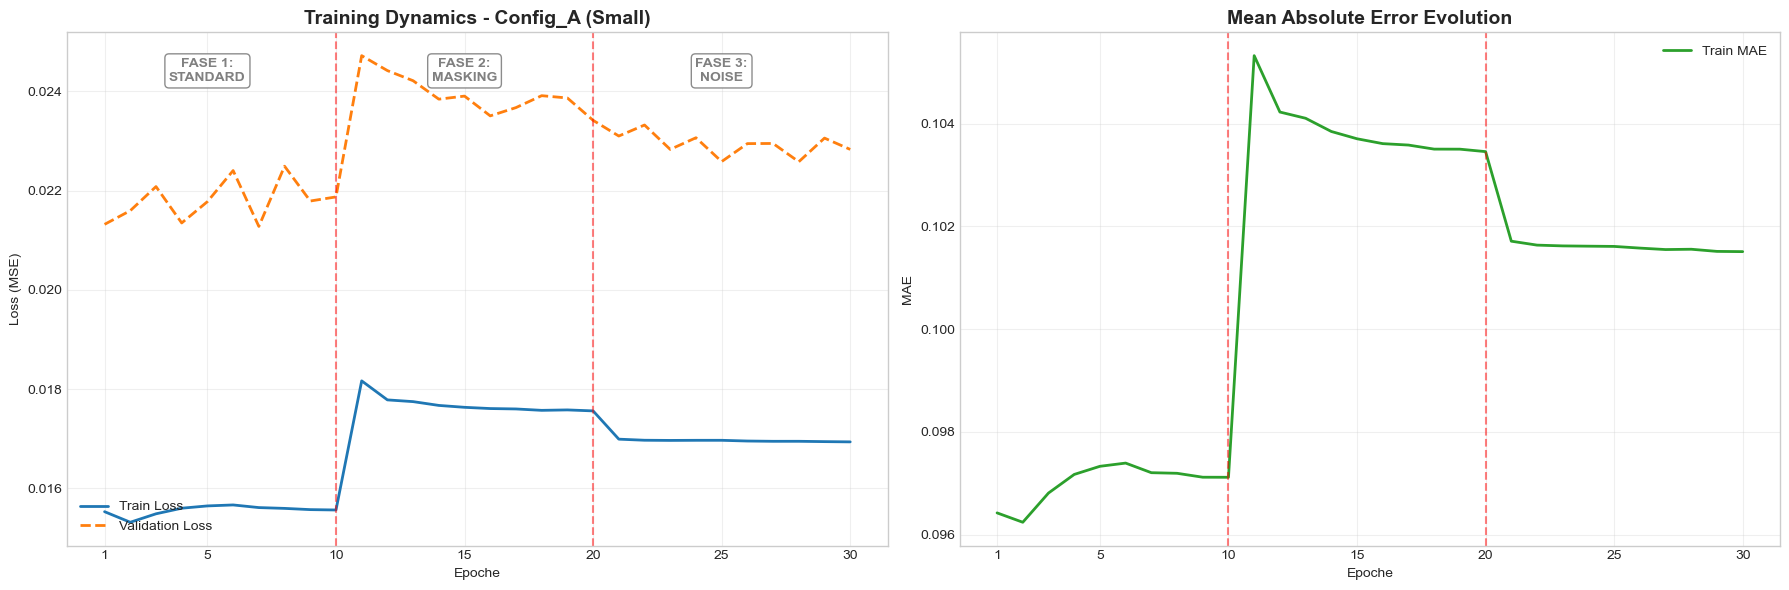

Generando grafici di predizione per: Config_A (Small)
Generazione predizioni per il grafico...


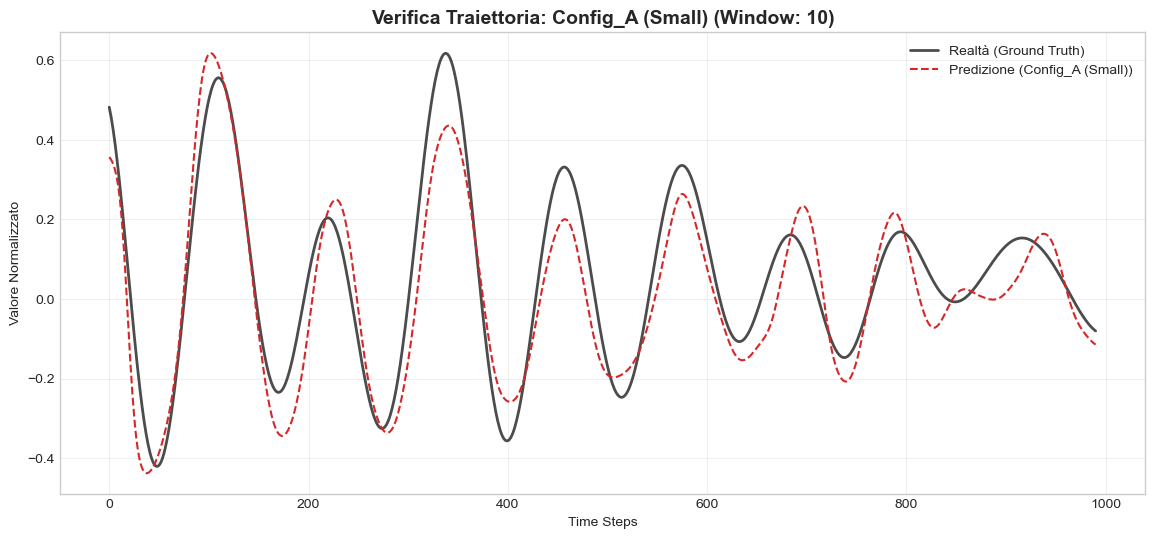


Generando grafici di addestramento per: Config_B (Medium - Standard)


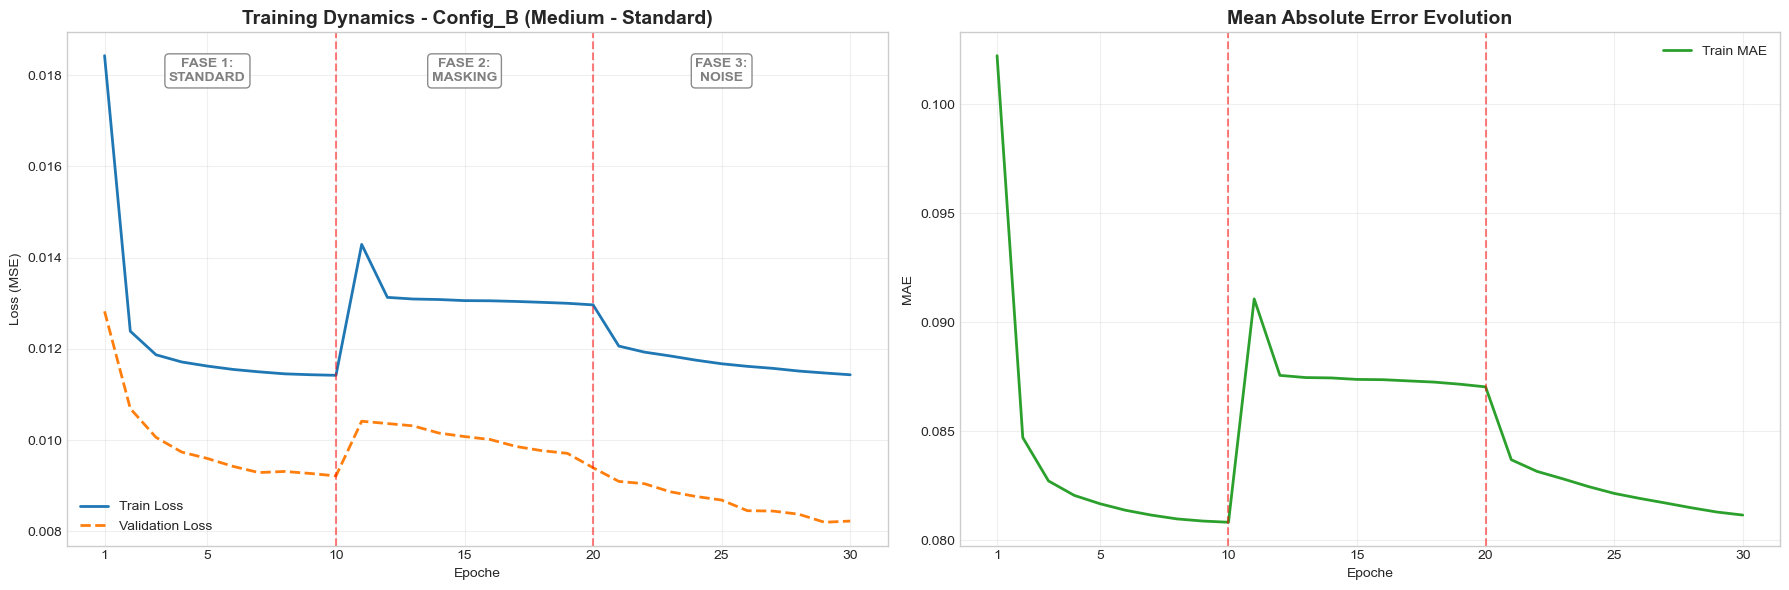

Generando grafici di predizione per: Config_B (Medium - Standard)
Generazione predizioni per il grafico...


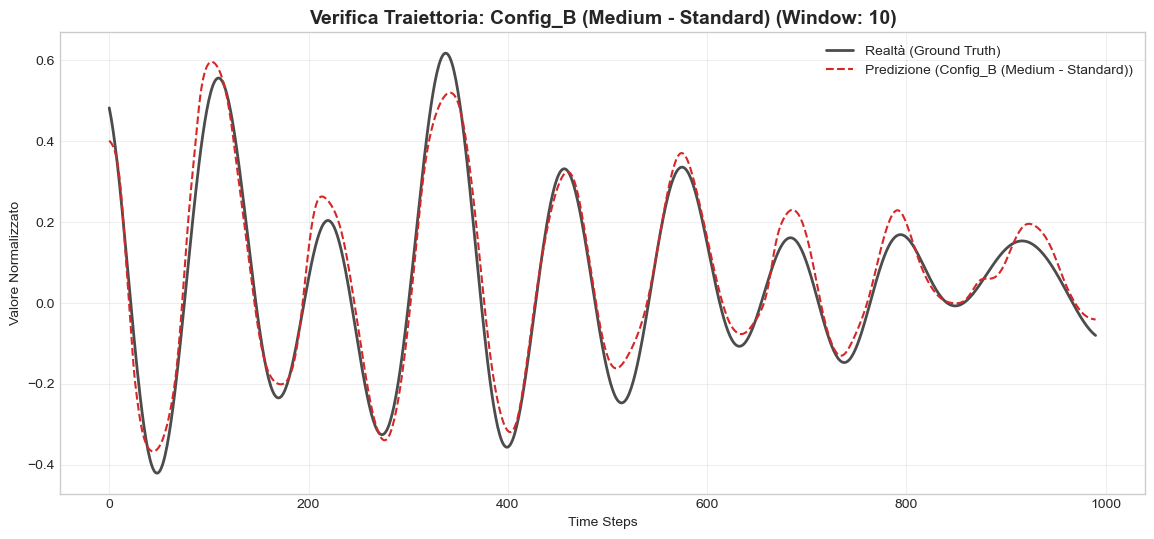


Generando grafici di addestramento per: Config_C (Large - Long Memory)


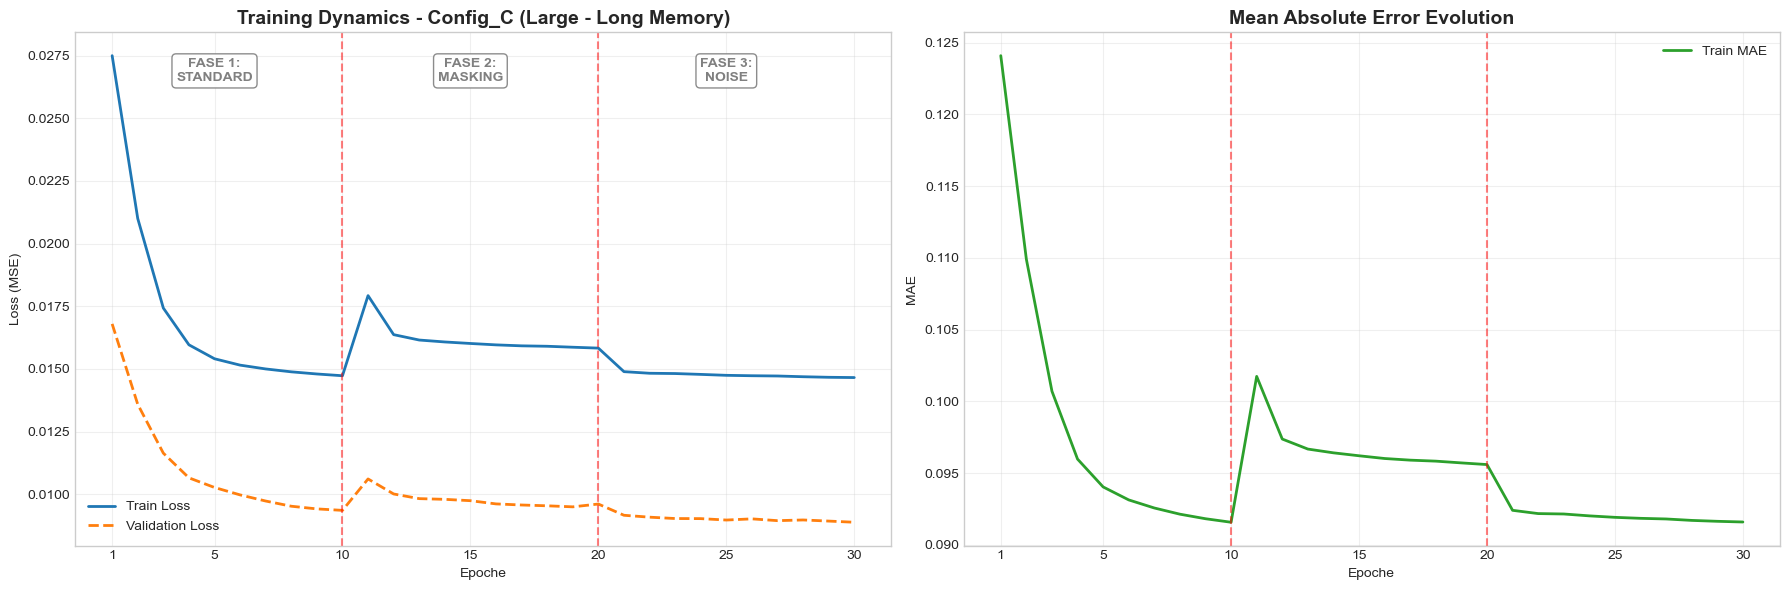

Generando grafici di predizione per: Config_C (Large - Long Memory)
Generazione predizioni per il grafico...


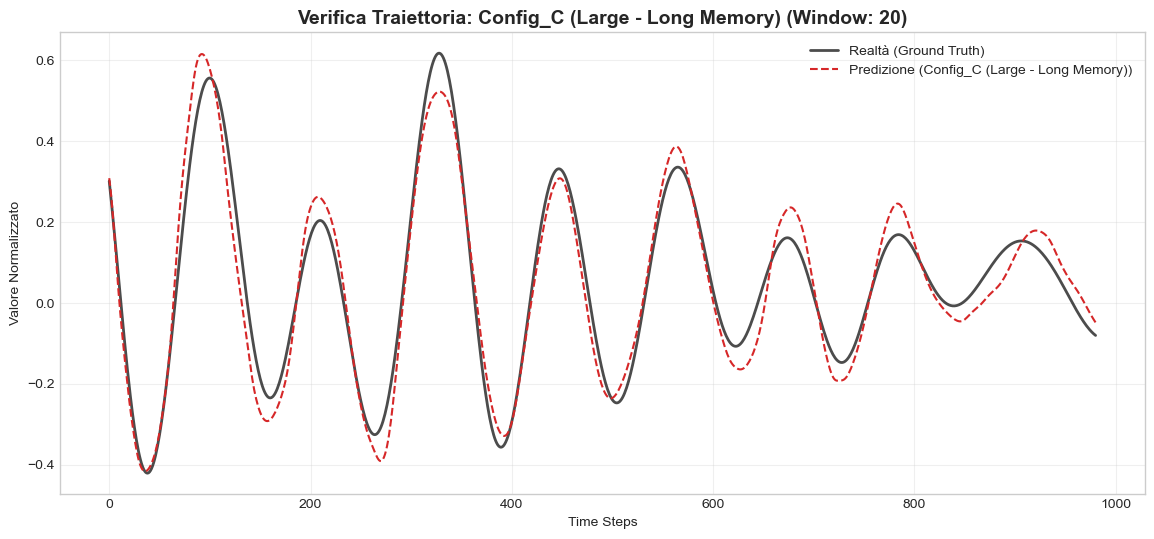


Generando grafici di addestramento per: Transf_B (Medium)


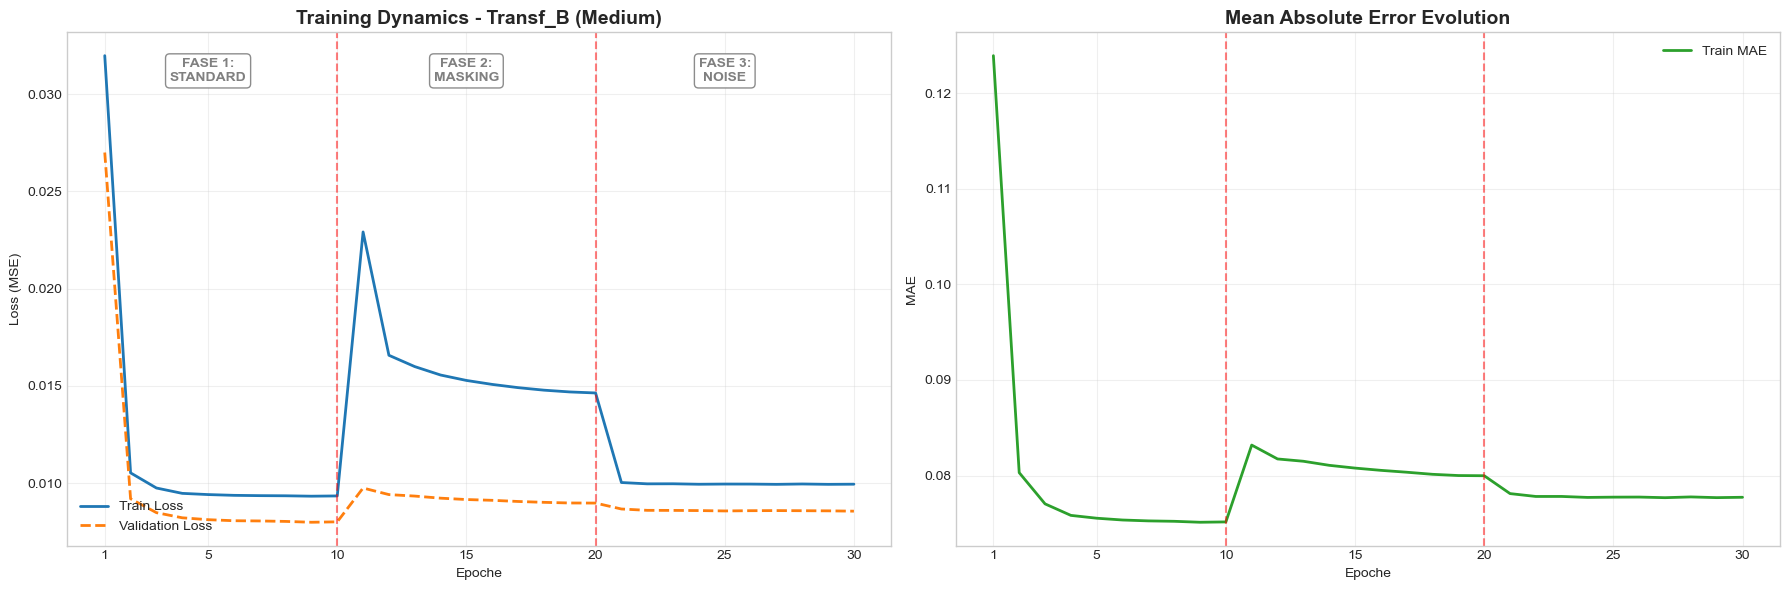

Generando grafici di predizione per: Transf_B (Medium)
Generazione predizioni per il grafico...


TypeError: tuple indices must be integers or slices, not tuple

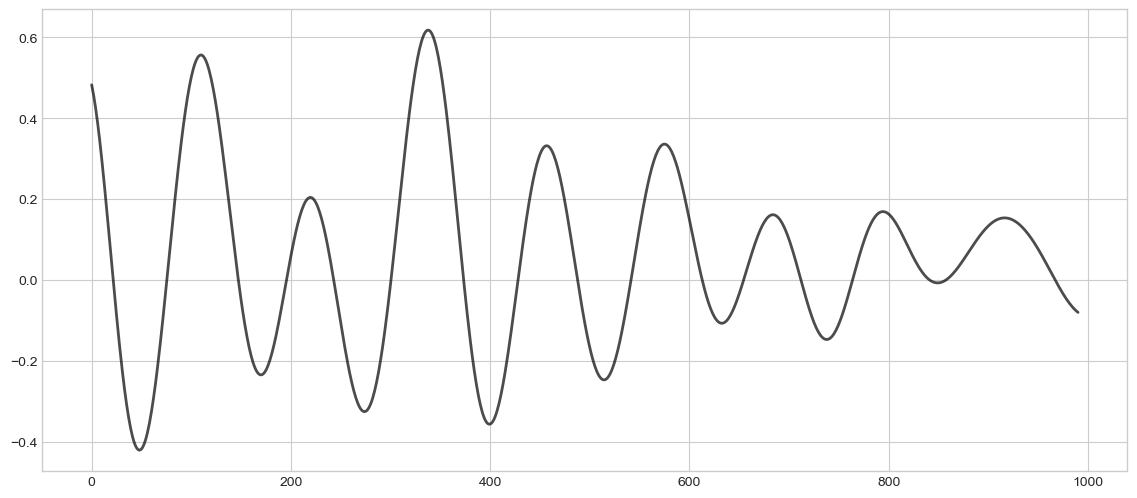

In [31]:
# --- CONFIGURAZIONE PERCORSI ---
MODEL_DIR = '../models'
PLOT_DIR = '../plots'
os.makedirs(PLOT_DIR, exist_ok=True)

def run_full_visualization_cycle():
    # Definiamo i gruppi di configurazioni da processare
    config_groups = {
        "rnn": HYPERPARAMETERS_LIST,
        "transf": TRANSFORMER_CONFIGS
    }

    for m_type, configs in config_groups.items():
        for conf in configs:
            name = conf['name']
            safe_name = name.replace(" ", "_").replace("(", "").replace(")", "")
            
            # 1. RECUPERO STORIA (CSV) E GRAFICI LOSS/MAE
            csv_path = f"{MODEL_DIR}/history/{m_type}_{safe_name}.csv"
            if os.path.exists(csv_path):
                print(f"\nGenerando grafici di addestramento per: {name}")
                history_df = pd.read_csv(csv_path)
                # Convertiamo il dataframe in dizionario per le tue funzioni
                history_dict = history_df.to_dict(orient='list')
                
                plot_filename = f"loss_{m_type}_{safe_name}.png"
                plot_training_phases_detailed(history_dict, name, plot_filename)
            else:
                print(f"Storia non trovata per {name} al percorso: {csv_path}")

            # 2. RICARICAMENTO MODELLO E GRAFICI PREDIZIONE
            weights_path = f"{MODEL_DIR}/weights/{m_type}_{safe_name}.weights.h5"
            if os.path.exists(weights_path):
                print(f"Generando grafici di predizione per: {name}")
                
                # Istanziamo l'architettura corretta
                if m_type == "rnn":
                    model = QuantumRNN(hidden_units=conf['units'], output_dim=55, dropout_rate=conf['dropout'])
                else:
                    model = QuantumTransformer(
                        num_layers=conf['num_layers'], embed_dim=conf['embed_dim'],
                        num_heads=conf['num_heads'], ff_dim=conf['ff_dim'],
                        output_dim=55, input_seq_len=conf['window_size'], dropout_rate=conf['dropout']
                    )
                
                # Dummy pass per inizializzare i pesi e caricamento
                dummy_input = tf.random.uniform((1, conf['window_size'], 55))
                _ = model(dummy_input)
                model.load_weights(weights_path)
                
                pred_filename = f"pred_{m_type}_{safe_name}.png"
                # Assicurati che test_traj_norm sia disponibile nel tuo ambiente
                plot_trajectory_check(model, test_traj_norm, conf['window_size'], name, pred_filename)
                
                # Pulizia memoria dopo ogni modello per evitare crash
                tf.keras.backend.clear_session()
            else:
                print(f"Pesi non trovati per {name} al percorso: {weights_path}")

# Avvia il ciclo
run_full_visualization_cycle()